## Nanostring Cosmx dataset

In [1]:
%%time
## Import the dataset
import pandas as pd
import numpy as np
### example codes
from utag import utag

FILE_PATH = "~/Documents/Research/github/SpaTopic_benchmarking/data/nanostring_example_lung5-1/data_utag_lung5-1.csv"
df = pd.read_csv(FILE_PATH)

/Users/xiyupeng/opt/anaconda3/envs/utag/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 5.32 s, sys: 2.26 s, total: 7.58 s
Wall time: 6.71 s


In [2]:
import anndata as ad
from scipy.sparse import csr_matrix
## prepare data
counts = csr_matrix(df.iloc[:,4:], dtype=np.float32)
adata = ad.AnnData(counts)
adata.obsm['spatial'] = df.iloc[:,1:3].values
adata.obs['celltype'] = df.iloc[:,3].values

In [3]:
df.columns[4:]

Index(['ABL1', 'ABL2', 'ACE', 'ACE2', 'ACKR1', 'ACKR3', 'ACKR4', 'ACTA2',
       'ACTG2', 'ACVR1',
       ...
       'NegPrb14', 'NegPrb15', 'NegPrb16', 'NegPrb17', 'NegPrb18', 'NegPrb19',
       'NegPrb20', 'NegPrb21', 'NegPrb22', 'NegPrb23'],
      dtype='object', length=979)

In [4]:
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = df.columns[4:]

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.22.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11
normalizing counts per cell
    finished (0:00:00)


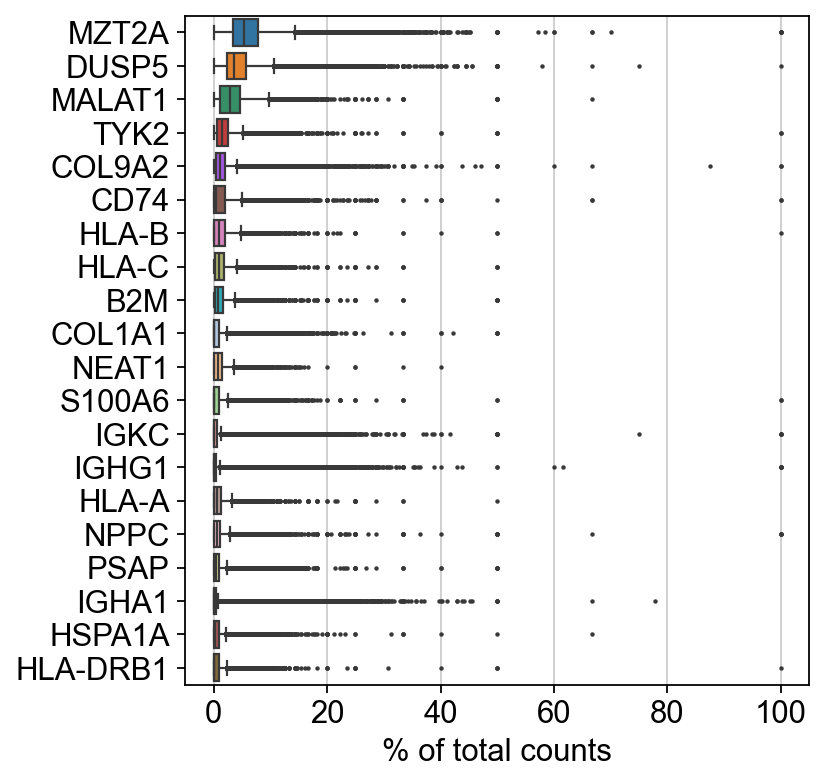

In [5]:
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor = "white")
sc.pl.highest_expr_genes(adata,n_top=20)

In [6]:
### Preprocessing
sc.pp.filter_genes(adata, min_cells=3) ## Basic filtering
sc.pp.log1p(adata)  ## log transform
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) ## only keep highly variable genes
adata = adata[:, adata.var.highly_variable]  
sc.pp.scale(adata, max_value=10)  ## scale and truncate

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/xiyupeng/opt/anaconda3/envs/utag/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


/Users/xiyupeng/opt/anaconda3/envs/utag/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


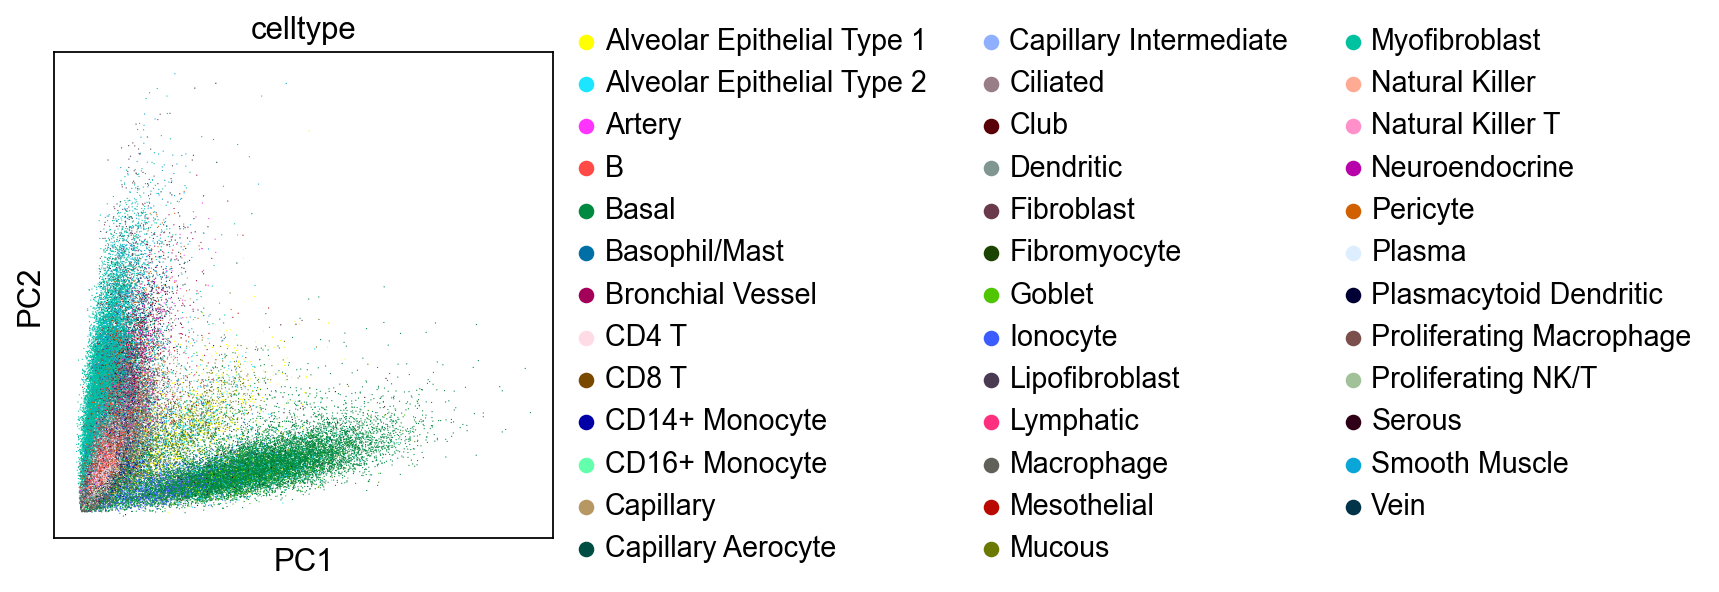

In [7]:
## PCA
sc.tl.pca(adata, svd_solver="arpack", n_comps = 50)  
sc.pl.pca(adata, color="celltype")

In [8]:
### create adata using pc as features 
adata_pca = ad.AnnData(adata.obsm['X_pca'][:,:])
adata_pca.obsm['spatial'] = df.iloc[:,1:3].values
adata_pca.obs['celltype'] = df.iloc[:,3].values
adata_pca.X  
### use as input on the server. Unable to run this part on my Mac  
adata_pca.write_h5ad(filename= "/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/data/nanostring_example_lung5-1/nanostring_lung_adata_input.h5ad")

array([[-3.2301214 , -3.9027085 , -1.9413011 , ..., -0.07473436,
        -0.04316048,  0.00692124],
       [-3.2060533 , -3.4757519 , -1.9297128 , ...,  0.04579274,
         0.14873579,  0.16099133],
       [-2.2995121 , -0.6868557 , -1.7925221 , ..., -0.3651696 ,
         0.07942356, -0.52101016],
       ...,
       [-2.0973053 ,  5.93343   , -3.6903045 , ...,  1.0534394 ,
         0.26864472, -0.16781619],
       [-1.7524899 , -1.4099559 ,  0.8733817 , ..., -0.42734042,
        -1.0038128 , -1.12588   ],
       [-3.2716186 , -4.0373735 , -1.4594043 , ..., -0.01098057,
        -0.0197509 ,  0.0278747 ]], dtype=float32)

In [ ]:
%%time
# Run UTAG on provided data
# run this part in the server. Unable to run this part on my Mac. 
# resolution is 0.18 um per pixel. thus change max_dist to 60
utag_results = utag(
    adata_pca,
    slide_key=None,
    max_dist=60,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.05, 0.1, 0.3, 0.5],
    parallel = False
)

Applying UTAG Algorithm...
Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:01)


In [9]:
utag_results.write_h5ad(filename= "/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/data/nanostring_example_lung5-1/nanostring_lung_adata_utag_result.h5ad")

## Healthy lung data

In [5]:
## example data https://anndata.readthedocs.io/en/latest/
###Use Scanpy to get a h5ad file with provided data
import scanpy as sc
adata = sc.read(
    'data/healthy_lung_adata.h5ad',
    backup_url='https://zenodo.org/record/6376767/files/healthy_lung_adata.h5ad?download=1')
adata.obs

,sample,obj_id,X_centroid,Y_centroid,roi,Diseased State,Age,Patient,Image Location,cell type,slide,topological_domain,id,domain,UTAG Label
0,UNC_59,19,3.000000,709.423077,UNC_59-01,Healthy,Younger,UNC_59,distal,Connective,IMC_0,V,UNC_59-01_19,Vessel,Airway wall
1,UNC_59,23,4.857143,608.690476,UNC_59-01,Healthy,Younger,UNC_59,distal,Connective,IMC_0,V,UNC_59-01_23,Vessel,Airway wall
2,UNC_59,25,5.500000,677.394737,UNC_59-01,Healthy,Younger,UNC_59,distal,Endothelial,IMC_0,V,UNC_59-01_25,Vessel,Vessel
3,UNC_59,26,4.900000,539.780000,UNC_59-01,Healthy,Younger,UNC_59,distal,Endothelial,IMC_0,AR,UNC_59-01_26,Alveolar space,Alveolar space
4,UNC_59,27,5.060345,90.517241,UNC_59-01,Healthy,Younger,UNC_59,distal,CD8 T cells,IMC_0,AR,UNC_59-01_27,Alveolar space,Alveolar space
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71941,SR00126_lung,1851,673.530120,18.674699,SR00126_lung-02,Healthy,Older,SR00126_lung,distal,Macrophages,IMC_9,AR,SR00126_lung-02_1851,Alveolar space,Airway wall
71942,SR00126_lung,1854,675.062016,397.906977,SR00126_lung-02,Healthy,Older,SR00126_lung,distal,Mast cells,IMC_9,AR,SR00126_lung-02_1854,Alveolar space,Airway wall
71943,SR00126_lung,1855,675.597222,36.736111,SR00126_lung-02,Healthy,Older,SR00126_lung,distal,Endothelial,IMC_9,AR,SR00126_lung-02_1855,Alveolar space,Alveolar space
71944,SR00126_lung,1856,676.203488,135.331395,SR00126_lung-02,Healthy,Older,SR00126_lung,distal,Endothelial,IMC_9,AR,SR00126_lung-02_1856,Alveolar space,Alveolar space


In [8]:
%%time
adata = utag(
    adata,
    slide_key="roi",
    max_dist=12,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden',
    resolutions = [0.05, 0.1, 0.3, 0.5],
    parallel = False
)

Applying UTAG Algorithm...


  0%|                                                                                                 | 0/4 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.05...


 25%|██████████████████████▎                                                                  | 1/4 [00:28<01:25, 28.55s/it]

Applying Leiden Clustering at Resolution: 0.1...


 50%|████████████████████████████████████████████▌                                            | 2/4 [01:14<01:17, 38.67s/it]

Applying Leiden Clustering at Resolution: 0.3...


 75%|██████████████████████████████████████████████████████████████████▊                      | 3/4 [02:29<00:55, 55.18s/it]

Applying Leiden Clustering at Resolution: 0.5...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:48<00:00, 57.13s/it]


In [9]:
adata.write_h5ad(filename= "/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/data/healthy_lung/healthy_lung_adata_labeled.h5ad")

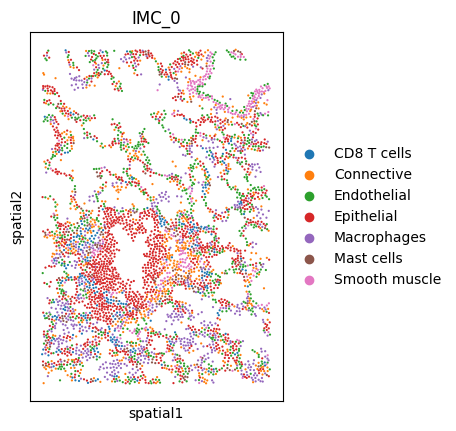

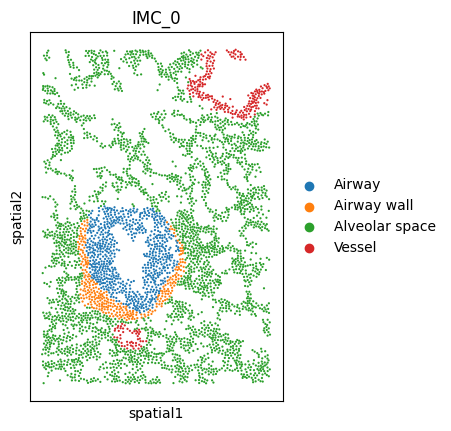

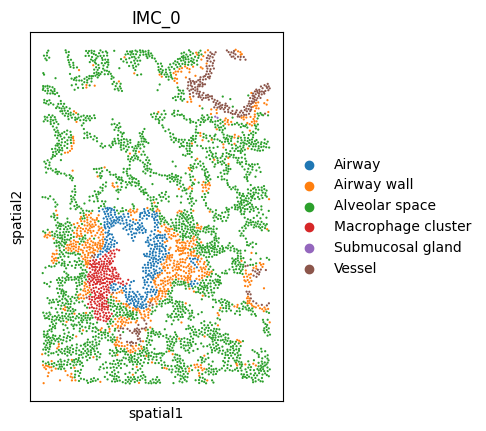

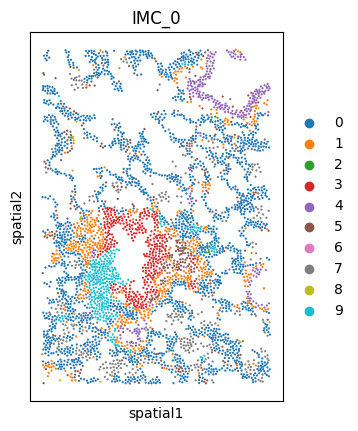

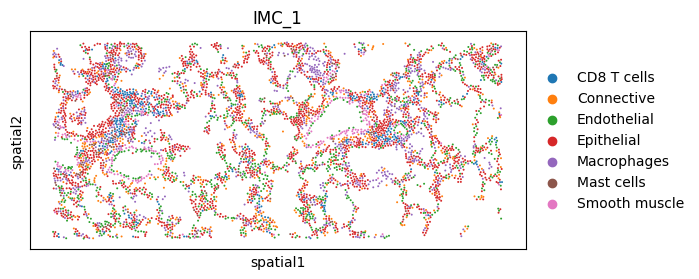

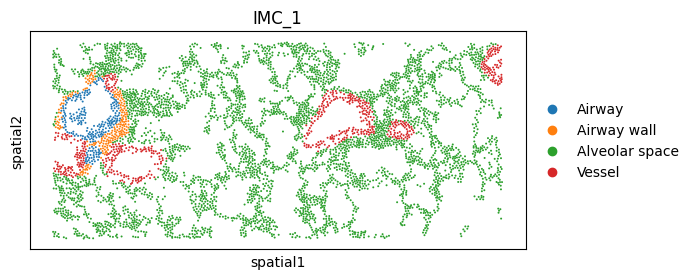

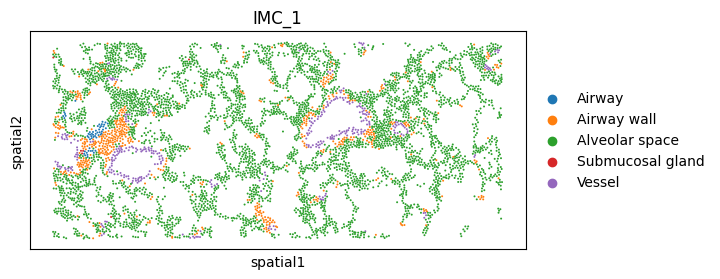

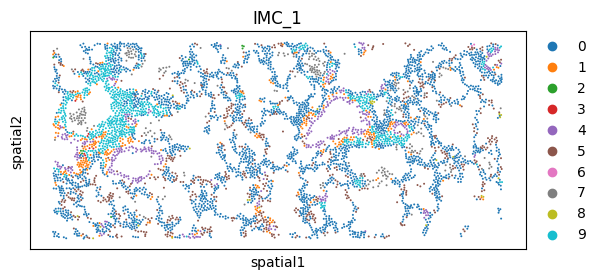

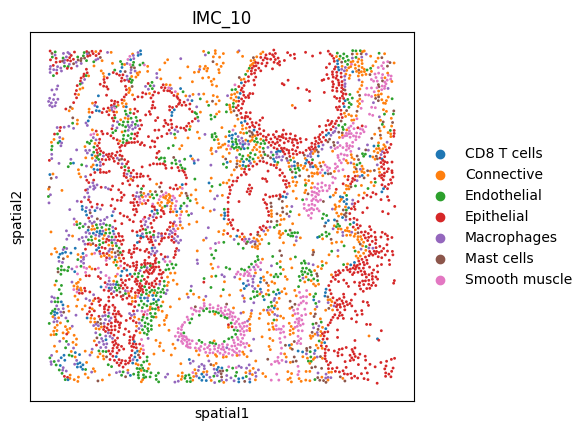

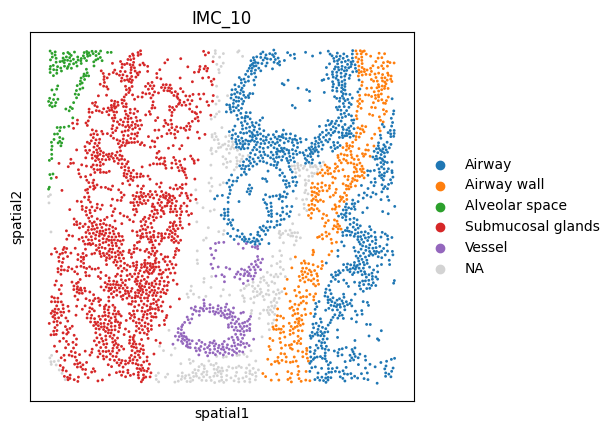

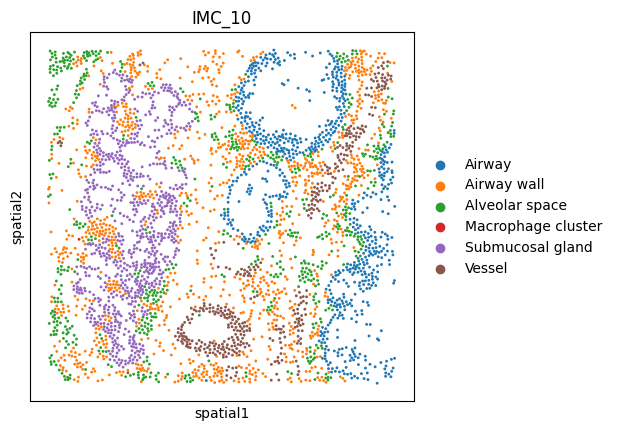

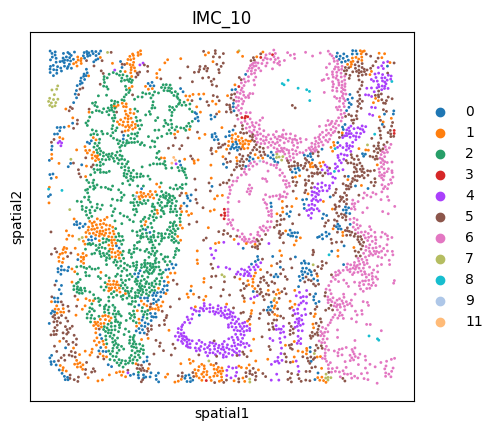

In [22]:
for img in adata.obs['roi'].unique()[:3]:
    a = adata[adata.obs['roi'] == img].copy()
    slide = a.obs['slide'].unique()[0]
    sc.pl.spatial(a, spot_size = 8, color = 'cell type', title = slide)
    sc.pl.spatial(a, spot_size = 8, color = 'domain', title = slide)
    sc.pl.spatial(a, spot_size = 8, color = 'UTAG Label', title = slide)
    sc.pl.spatial(a, spot_size = 8, color = 'UTAG Label_leiden_0.5', title = slide)

## Mouse spleen 

In [1]:
import pandas as pd
import numpy as np
from utag import utag
import scanpy as sc

## read mouse spleen dataset
df = pd.read_pickle("/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/data/mouse_spleen_data/spleen_df.pkl")

/Users/xiyupeng/opt/anaconda3/envs/utag/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### combine images
combined_df = pd.concat(df, keys=df.keys())
colnames30 = combined_df.columns[1:30]
desired_columns = colnames30.tolist() + [combined_df.columns[33]]
combined_df.loc[:,desired_columns]

CD45        Ly6C          TCR        Ly6G         CD19  \
BALBc-1 7       5666.397949 -155.011398  -427.121613  -53.596302   696.744141   
        10      7034.170898 -161.461090   738.726929  -52.546940  1373.622925   
        14      1873.250610  381.250488   502.290131  205.504501   803.336243   
        16      3770.339111  -91.655739  -760.648010  -44.789978   362.723816   
        20      9060.431641 -186.782639  1443.815308  -19.553146  2401.723389   
...                     ...         ...          ...         ...          ...   
MRL-9   496273  2367.948730  251.316635   395.453094  113.970482   250.219864   
        496274  -627.104187  324.110138 -2862.585449   16.187679   237.158447   
        496276   688.267334  -70.908699  -160.905029   61.399487   196.832733   
        496282  1006.385193 -188.356293   465.254303 -191.436920   272.241089   
        496285  1095.304321  -74.188034  -100.120903   22.386854   322.410767   

                      CD169        CD106          CD3       CD1632  \
BALBc-1 7       -488.727325   349.676666  -450.499329   805.963440   
        10      -636.755981  1856.957031  -443.563812  2390.583252   
        14      -153.537766  -668.360718  -142.203369  -294.623016   
        16      -390.926819   269.888702  -354.102997   598.464417   
        20     -1091.332275  4447.319824 -1541.089600  3990.296387   
...                     ...          ...          ...          ...   
MRL-9   496273   263.974274  4186.838379   403.053345  2167.403809   
        496274  -182.428680  1467.491211  -240.797119   416.847931   
        496276   127.113312  1869.867188   175.711349   781.971619   
        496282  -725.880798   575.814880  -559.138611   431.615845   
        496285   -40.220577  1921.486816  -517.223450   492.039246   

                       CD8a  ...         CD31           CD4          IgM  \
BALBc-1 7         32.486767  ...   958.392395   1022.542786   522.774048   
        10      1147.092896  ...  2247.579590    807.692139   758.649780   
        14      1147.046631  ...     0.409898    -67.415993    32.703056   
        16       471.436676  ...  1638.168701   1523.812622   189.708466   
        20       104.243660  ...  3534.322754    587.997620   439.125580   
...                     ...  ...          ...           ...          ...   
MRL-9   496273  1814.283936  ...  1112.179932  10722.639648  1085.465698   
        496274    69.365486  ...   380.770355   6643.289062   209.143204   
        496276  -133.900894  ...   482.475494   7554.388672  1352.387451   
        496282  -171.742752  ...   324.405975   3592.366211   193.735931   
        496285    62.606819  ...  1005.910156   7894.604004   204.981781   

                       B220        ERTR7        CD35      CD2135         CD44  \
BALBc-1 7        610.681946    25.253965  303.551788  -72.868912   480.301727   
        10      2639.101807    96.470924  295.682068  -17.080685  5726.068359   
        14        75.475098    -3.261004  460.099731  -15.009765   -36.286858   
        16      1985.436157  1306.317017  333.080353   99.129906  1156.182617   
        20       691.991455  1375.179199  814.796509   44.625690  6838.815918   
...                     ...          ...         ...         ...          ...   
MRL-9   496273   117.819099  2858.167480  -67.832283  112.664314  5435.308594   
        496274  -260.342377   784.387329  117.810364    5.938745  3004.209961   
        496276   123.229073  1496.286255   87.959900   26.940754  2237.358887   
        496282  2600.466309   139.416122  774.678162  560.089783  1277.456177   
        496285    19.450420   320.106537   88.575180  -32.845268  3312.369141   

                     NKp46        MHCII  
BALBc-1 7       251.533127  2400.150635  
        10      542.633911  4161.321777  
        14       75.619591  2109.939209  
        16      340.465698  2117.208984  
        20      735.213928  9903.355469  
...                    ...          ...  
MRL-9   496273  759.681885   

In [4]:
import anndata as ad
from scipy.sparse import csr_matrix
## prepare data
counts = csr_matrix(combined_df.loc[:,desired_columns], dtype=np.float32)
mousedata = ad.AnnData(counts)
mousedata.obsm['spatial'] = combined_df.iloc[:,41:43].values
mousedata.obs['celltype'] = combined_df.iloc[:,44].values
mousedata.obs['sample'] = combined_df.iloc[:,38].values

In [5]:
#### scale
sc.pp.scale(mousedata, max_value=10)  
### batch corrrection
sc.pp.combat(mousedata,'sample')
#### rescale
sc.pp.scale(mousedata, max_value=10)  

In [6]:
%%time
### Utag works for one image  reso 188 nm/pixel. may change max_dist to 60
mousedata = utag(
    mousedata,
    slide_key="sample",
    max_dist=60,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden',
    resolutions = [0.05, 0.1, 0.2, 0.3],
    parallel = False
)

Applying UTAG Algorithm...


  0%|                                                                                  | 0/4 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.05...


 25%|█████████████████▌                                                    | 1/4 [21:12<1:03:37, 1272.46s/it]

Applying Leiden Clustering at Resolution: 0.1...


 50%|██████████████████████████████████                                  | 2/4 [1:26:30<1:34:16, 2828.43s/it]

Applying Leiden Clustering at Resolution: 0.2...


 75%|████████████████████████████████████████████████████▌                 | 3/4 [2:21:58<50:56, 3056.96s/it]

Applying Leiden Clustering at Resolution: 0.3...


100%|██████████████████████████████████████████████████████████████████████| 4/4 [3:06:23<00:00, 2795.75s/it]

CPU times: user 3h 18min 46s, sys: 16min 49s, total: 3h 35min 36s
Wall time: 3h 33min 48s


In [7]:
mousedata.write_h5ad(filename= "/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/data/mouse_spleen_data/mouse_spleen_adata_labeled_bat_corrected_multi_res_max_dist60.h5ad")